# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [2]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from scipy.io import wavfile


## Functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [4]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [5]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [6]:
play = False
if play :
    play_sound(sound) 

## 1 Conversion of sampling rate
1. Le rapport des fréquences d'échantillonages est: $\frac{32 000}{48 000}= \frac{2}{3}$
On a donc ici un rééchantillonnage, pour passer de 48khz à 32 khz. $\frac{L}{M}=\frac{2}{3}$

Le filtre passe-bas résultant de la fusion des filtres passe-bas liés au sur-échantillonnage et au sous-échantillonnage est:

$\begin{pmatrix}
H((e^{2i\pi\nu})) = 2, \forall |\nu| \leq \frac{1}{6} \\
H((e^{2i\pi\nu})) =0, \forall \frac{1}{6} \leq |\nu| \leq \frac{1}{2}
\end{pmatrix}$

2. Synthetize impulse response of the filter.

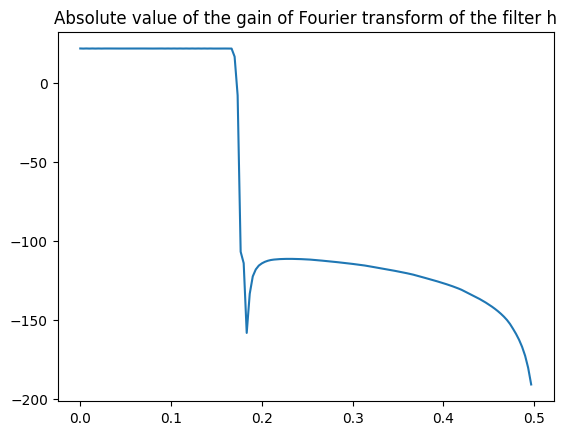

In [7]:
#2  filter synthesis
len_filter = 300
epsilon = 0.01
nu_a= 1/6 + epsilon  # epsilon is the distance between the beginning of the transition phase and the end of the transition phase
nu_c = 1/6

h = scipy.signal.remez(len_filter,[0,nu_c,nu_a,.5],[3,0])
H = np.fft.fft(h)
F_array = np.fft.fftfreq(len(H))

Gain = 20*np.log(np.abs(H[0:len(H)//2]))

plt.title('Absolute value of the gain of Fourier transform of the filter h')
plt.plot(F_array[0:len(H)//2],Gain)
plt.show()


3. Program the simplest digital processing chain that will permit you to achieve the conversion

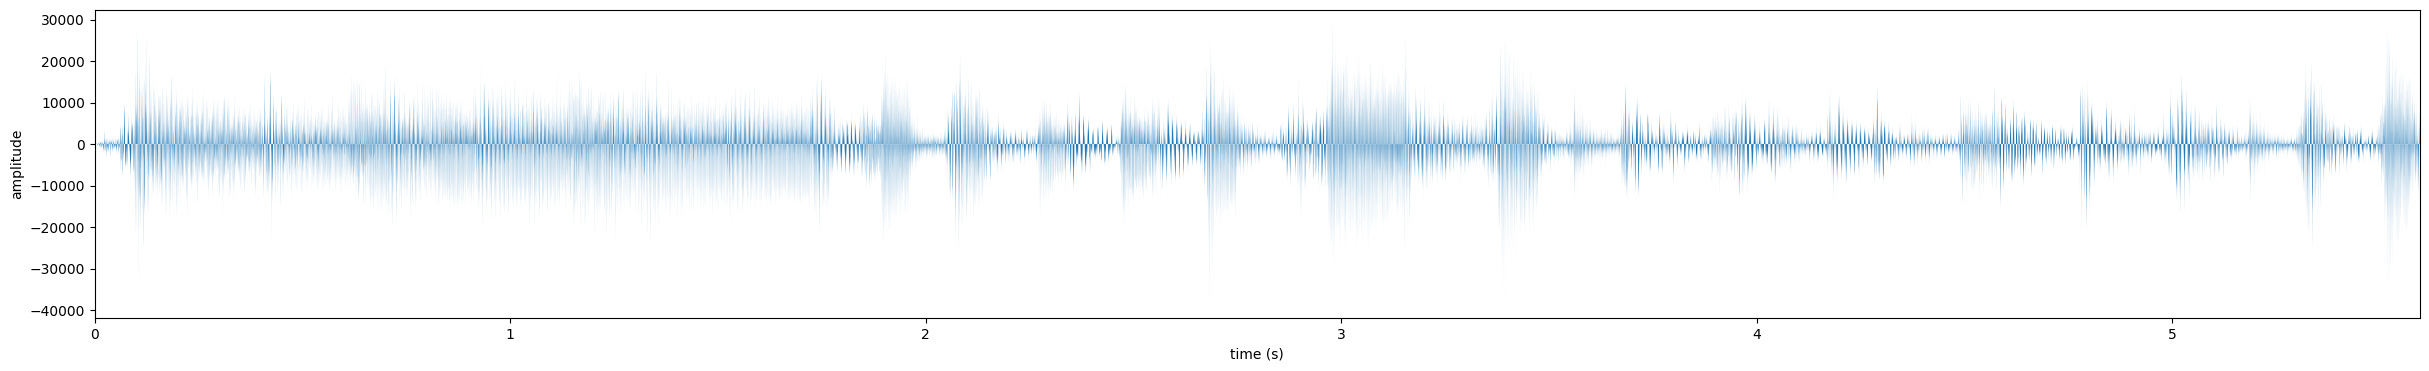

In [8]:
#3 conversion code

sample_rate, audio_data = wavfile.read('caravan_48khz.wav')

Fs = sample_rate

x = np.array(audio_data)

l = len(x)


# Upsampling 
w = np.zeros(2 * l)
for i in range(l):
    w[2 * i] = x[i]

# Filter

y = scipy.signal.lfilter(h, a=1, x=w)

# Downsampling

D = np.zeros(l//3)
for i in range(len(D)):
    D[i] = y[3*i]

# Generate time axis
timestep = 1 / float(Fs)
times = np.arange(len(D)) * timestep

plot_sound(D, times)

4. This equivalence permits to do the calculus on a smaller sample, we don't work on the sample that is two times the size of the original sample.



![Proof of equivalence](equivalenc_proof.jpeg)


In [9]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

5. Polyphase decompositions

![polyphase decomposition 1](part1_polyphase.jpeg)

![polyphase decomposition 2 ](part2_polyphase.jpeg)

In [10]:
#We define a more general function to compute the upsampling and downsampling arrays 
#that will be used on question 5

def chain_upsample(M,x):
    #M is the order for the upsampling
    #x is the input signal
    #This function performs the upsampling
    w = np.zeros(M*len(x))
    for i in range(len(x)):
        w[M*i] = x[i]
    return w

def chain_downsample(L,x):
     #L is the order for the downsampling
     #x is the input signal
    D = np.zeros(len(x)//L, dtype=np.complex128)
    for i in range(len(D)):
        D[i] = x[L*i]
    return D

In [11]:
#5 Efficient implementation
sample_rate, audio_data = wavfile.read('caravan_48khz.wav')

Fs = sample_rate

x = np.array(audio_data)
l = len(x)
#We use these decompostions to program the efficient implementation of the algorithm

#Downsampling and upsampling factors
M=2
L=3

#We make the polyphase decomposition
R0 = H[::2]
R1 = H[1::2]

R00 = R0[::3]
R01 = R0[1::3]
R02 = R0[2::3]

R10 = R1[::3]
R11 = R1[1::3]
R12 = R1[2::3]

Array_Polyphase=np.array([[R00, R01, R02],[R10, R11,R12]])


##### First,we deal with the upper part of the diagram
#let's call y1 the output of the first part of the chain with R00,R01,R02
x1 = np.roll(x,1)


Y1 =[] #List to store the different outputs in the first part of the canal

for e in range(L):
    h_current = Array_Polyphase[0][e]
    x1_tmp = np.roll(x1,-e) #We shift the input signal by e steps
    y_tmp = chain_downsample(L,x1_tmp)
    y1_tmp =  scipy.signal.lfilter(h_current, a=1, x=y_tmp)
    Y1.append(y1_tmp)

y1_tmp = Y1[0]+Y1[1]+Y1[2]

y1 = np.roll(chain_upsample(M,y1_tmp),-1)
##### Second,we deal with the lower part of the diagram
#let's call y2 the output of the second part of the chain with R10,R11,R12

Y2 = [] #List to store the different outputs in the second part of the canal
for e in range(L):
    h_current = Array_Polyphase[1][e]
    x_tmp = np.roll(x1,-e) #We shift the input signal by e steps
    y_tmp = chain_downsample(L,x_tmp)
    y2_tmp =  scipy.signal.lfilter(h_current, a=1, x=y_tmp)
    Y2.append(y2_tmp)

y2_tmp = Y2[0]+Y2[1]+Y2[2]
y2 = chain_upsample(M,y2_tmp)

###########

output_signal = y1+y2

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11520\17319306.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  w[M*i] = x[i]


In [12]:
Fs_resample = 32000
write('caravan_polyphase.wav', Fs_resample, np.array(output_signal, dtype=np.int16))

In [13]:
print(output_signal)

[ 0.         -3.00158528  2.99197862 ...  3.88677918 -3.28741671
  0.        ]


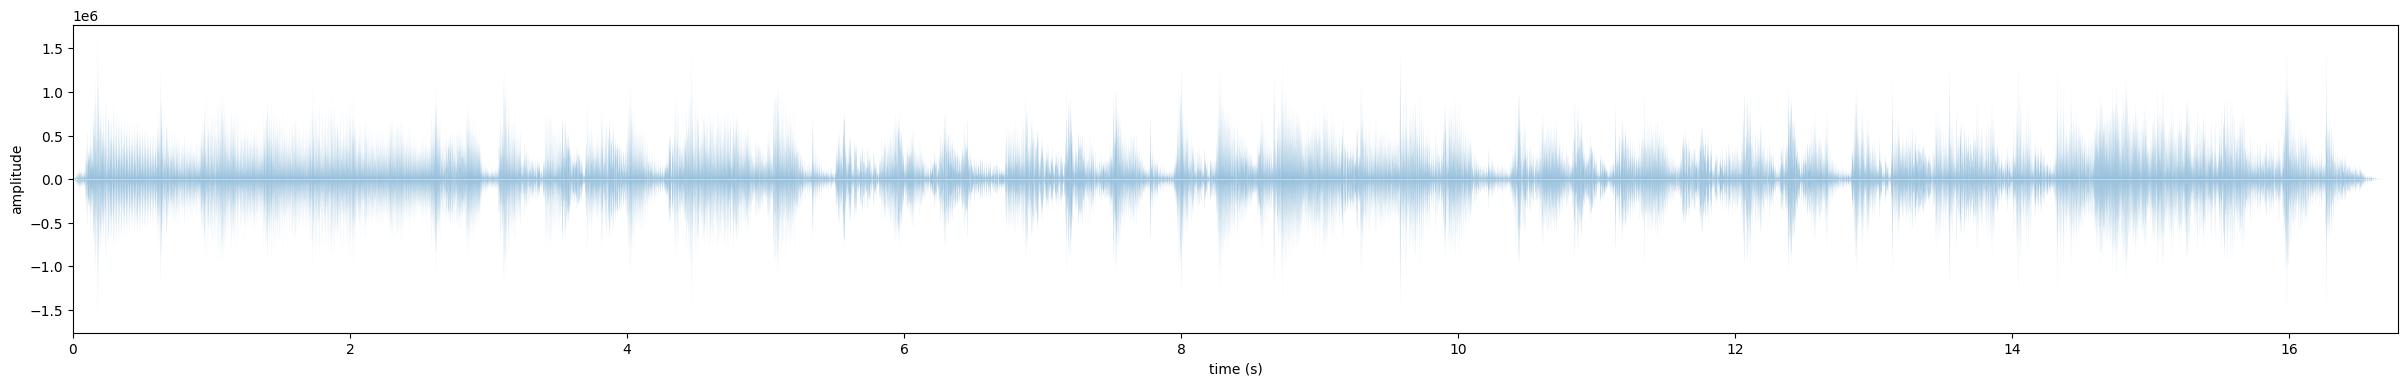

In [14]:
timestep = 1 / float(Fs_resample)
times = np.arange(len(output_signal)) * timestep

plot_sound(output_signal, times)

In [15]:
IPython.display.Audio(data = output_signal,rate=32000)
# On reconnait le signal initial

## 2 Signal analysis with the STFT

1. Hamming Window

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11520\220121964.py:10: RuntimeWarning: divide by zero encountered in log10
  W_log = 20*np.log10(np.abs(W))


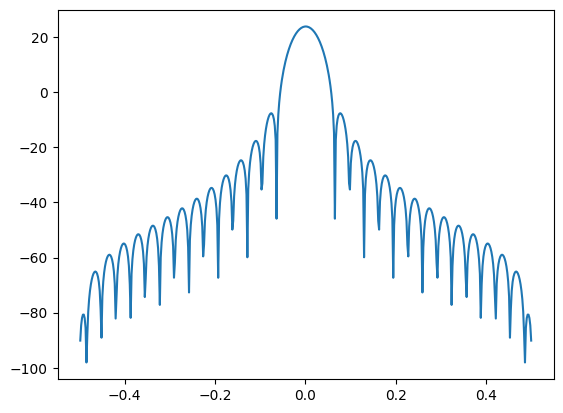

In [16]:
#1 Window
Nw = 32
M= 512
w = np.hanning(Nw)

W = np.fft.fft(w,M)
W = np.fft.fftshift(W)
Freq = np.linspace(-1/2,1/2,M)

W_log = 20*np.log10(np.abs(W))
plt.plot(Freq,W_log)

plt.show()

2. Par symétrie de la fenêtre de Hamming on a:

$W_x(\lambda,b)= \sum_{n\in Z}x(n)e^{-j2\pi \lambda n}w(b-n) = (g_{\lambda}*w)(b)$

Avec $g_{\lambda}(n)= x(n)e^{-2j \pi \lambda n}$

En passant dans le domaine de Fourier on a:

$DFT(g_{\lambda})(f)= DFT(x)(f-\lambda N)$, On a un shift.

Finalament:

$DFT(W_x(\lambda))(f) = DFT(x)(f- \lambda N) DFT(w)(f)$

Ainsi la STFT effectue dans le domaine de Fourier un repositionnement du signal autour de $\lambda N$ et un filtrage avec la fenêtre de Hamming.

La fenêtre de Hamming est symétrique, donc et comme N est pair dans notre cas c'est un type 2



3. Par changement de variable k=n+b on a:

$\tilde X (\lambda, b)=e^{j 2 \pi b \lambda} \sum_{k \in Z} x(k)w(k-b)e^{-j2 \pi k \lambda}=e^{j 2 \pi b \lambda} W_x(\lambda,b)$

On a ici un déphasage dans le domaine fréquentielle, avec cette nouvelle notation, ce qui créer un déclage dans le domaine temporel. 

4. 

In [17]:
sample_rate, audio_data = wavfile.read('caravan_48khz.wav')
x = np.array(audio_data)
N = x.shape[0] # % longueur du signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M/2+1

Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

Xtilde = np.zeros((M, Nt), dtype=complex)  # Matrice pour stocker les résultats

for u in np.arange(Nt): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    Xtilde[:,u] = X
    
def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [18]:
#spectrogram Xtilde
'''plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
            '''

IndentationError: unexpected indent (565623251.py, line 3)

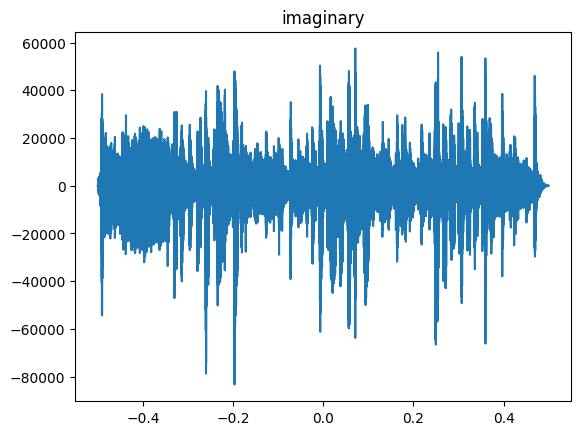

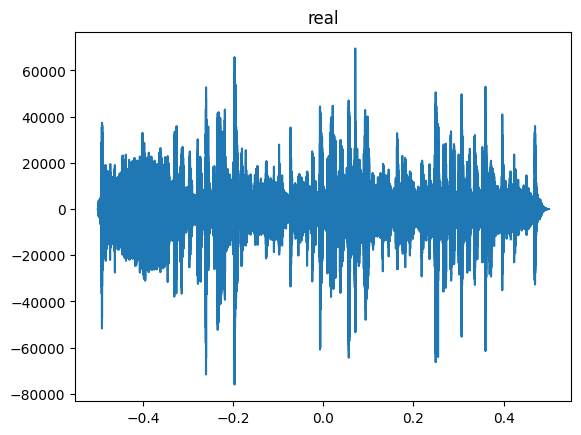

[0.53557683-1.20668801j 1.35472373-0.75629552j 1.92572025+0.13041262j ...
 0.3298334 -2.21898458j 0.99522213-2.00030278j 1.53828948-1.55450198j]


In [19]:
u = np.linspace(-0.5,0.5,len(Xtilde[0]))
x3 = Xtilde[2,:]
x3_real = np.real(x3)
x3_im = np.imag(x3)


plt.figure('imaginary')
plt.title('imaginary')
plt.plot(u,x3_im)

plt.figure('real')
plt.title('real')
plt.plot(u,x3_real)
plt.show()
print(x3)

On voit que la partie imaginaire de x3 n'est pas nulle, le signal est donc complexe.

5. Perfect reconstrucion

$y(n) = \sum_{u\in Z} \frac{1}{M} \sum_{k=0}^{M-1} \tilde{X}(k,u) e^{j 2 \pi \frac{k(n-uR)}{M}}w_s(n-uR)=\sum_{u \in Z} \frac{1}{M} \sum_{k=0}^{M-1} \sum_{m=0}^{M-1} x(m+k)w(m)e^{-2\pi j \frac{km}{M} } e^{j 2 \pi \frac{k(n-uR)}{M}}w_s(n-uR)$

$y(n)=\sum_{u\in Z} w_s(n-uR) \sum_{m=0}^{M-1} x(m+k)w(m) \frac{1}{M} \sum_{k=0}^{M-1} e^{j 2 \pi \frac{k}{M}(n-m-uR)}$

We can notice that:
$\frac{1}{M} \sum_{k=0}^{M-1} e^{j 2 \pi \frac{k}{M}(n-m-uR)}= 1_{(n-m-uR)\in MZ}$

$m \in [0,M-1]$ this implies that $m=n-uR$

$y(n)= \sum_{u\in Z} w_s(n-uR)  w(n-uR) x(n) = x(n) \sum_{u\in Z} w_s(n-uR)  w(n-uR)$

It implies that $\forall n, \sum_{u\in Z} w_s(n-uR)  w(n-uR)=1$

## Overlap-add reconstruction

In [20]:
#5
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output